In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)             
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()
# Mini-batch        instance 0, instance 1, instance 2, instance 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 3
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [3]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [4]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


## static_rnn()

In [5]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

In [13]:
init = tf.global_variables_initializer()
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "e:/tmp/chap14/tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

with tf.Session() as sess:
    file_writer = tf.summary.FileWriter(logdir, sess.graph) 
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    run_metadata = tf.RunMetadata()
    file_writer.add_run_metadata(run_metadata, "step")
    #file_writer.add_summary()
    file_writer.close()

In [7]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [13]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968948, -0.5922594 , -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

### Packing sequence

In [14]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1,0,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [20]:
X_batch = np.array([
    # t = 0 t = 1
    [[0, 1, 2], [9, 8, 7]], # instance 0
    [[3, 4, 5], [0, 0, 0]], # instance 1
    [[6, 7, 8], [6, 5, 4]], # instance 2
    [[9, 0, 1], [3, 2, 1]], # instance 3
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [21]:
outputs_val

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504,
         -0.45732826],
        [-0.9428799 , -0.9998869 ,  0.94055814,  0.9999985 ,
         -0.9999997 ]],

       [[-0.8001535 , -0.9921827 ,  0.7817797 ,  0.9971032 ,
         -0.9964609 ],
        [-0.637116  ,  0.11300927,  0.5798437 ,  0.4310559 ,
         -0.6371699 ]],

       [[-0.93605185, -0.9998379 ,  0.9308867 ,  0.9999815 ,
         -0.99998295],
        [-0.9165386 , -0.9945604 ,  0.896054  ,  0.99987197,
         -0.9999751 ]],

       [[ 0.9927369 , -0.9981933 , -0.55543643,  0.9989031 ,
         -0.9953323 ],
        [-0.02746338, -0.73191994,  0.7827872 ,  0.9525682 ,
         -0.9781773 ]]], dtype=float32)

In [22]:
np.transpose(outputs_val, axes=[1, 0, 2])[1]

array([[-0.9428799 , -0.9998869 ,  0.94055814,  0.9999985 , -0.9999997 ],
       [-0.637116  ,  0.11300927,  0.5798437 ,  0.4310559 , -0.6371699 ],
       [-0.9165386 , -0.9945604 ,  0.896054  ,  0.99987197, -0.9999751 ],
       [-0.02746338, -0.73191994,  0.7827872 ,  0.9525682 , -0.9781773 ]],
      dtype=float32)

## dynamic_rnn()

In [23]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [24]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [25]:
init = tf.global_variables_initializer()

X_batch =  np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [27]:
outputs_val

array([[[-0.85115266,  0.87358344,  0.5802911 ,  0.8954789 ,
         -0.0557505 ],
        [-0.999996  ,  0.99999577,  0.9981815 ,  1.        ,
          0.37679607]],

       [[-0.9983293 ,  0.9992038 ,  0.98071456,  0.999985  ,
          0.25192663],
        [-0.7081804 , -0.0772338 , -0.85227895,  0.5845349 ,
         -0.78780943]],

       [[-0.9999827 ,  0.99999535,  0.9992863 ,  1.        ,
          0.5159072 ],
        [-0.9993956 ,  0.9984095 ,  0.83422637,  0.99999976,
         -0.47325212]],

       [[ 0.87888587,  0.07356028,  0.97216916,  0.9998546 ,
         -0.7351168 ],
        [-0.9134514 ,  0.3600957 ,  0.7624866 ,  0.99817705,
          0.80142   ]]], dtype=float32)

## Variable Sequence Length

In [28]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [30]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [31]:
init = tf.global_variables_initializer()

X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
outputs_val

array([[[ 0.20123261,  0.8485545 ,  0.9367546 , -0.64976275,
          0.24727657],
        [ 0.9999977 ,  0.9999998 ,  1.        , -0.9948769 ,
          0.9394541 ]],

       [[ 0.98114127,  0.9996771 ,  0.9999982 , -0.9795104 ,
          0.7208298 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.99972755,  0.9999994 ,  1.        , -0.9989911 ,
          0.916424  ],
        [ 0.99992263,  0.99983186,  1.        , -0.91878283,
          0.6966661 ]],

       [[ 0.9996366 ,  0.99158496,  0.99998814, -0.99899435,
          0.9882074 ],
        [ 0.9949612 ,  0.913094  ,  0.9943361 , -0.06307561,
          0.16509786]]], dtype=float32)

In [33]:
states_val

array([[ 0.9999977 ,  0.9999998 ,  1.        , -0.9948769 ,  0.9394541 ],
       [ 0.98114127,  0.9996771 ,  0.9999982 , -0.9795104 ,  0.7208298 ],
       [ 0.99992263,  0.99983186,  1.        , -0.91878283,  0.6966661 ],
       [ 0.9949612 ,  0.913094  ,  0.9943361 , -0.06307561,  0.16509786]],
      dtype=float32)

## Training sequence classifier

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [37]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("e:/tmp/data")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting e:/tmp/data\train-images-idx3-ubyte.gz
Extracting e:/tmp/data\train-labels-idx1-ubyte.gz
Extracting e:/tmp/data\t10k-images-idx3-ubyte.gz
Extracting e:/tmp/data\t10k-labels-idx1-ubyte.gz


In [38]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(iteration)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9260274 Test accuracy: 0.9202
1 Train accuracy: 0.92876714 Test accuracy: 0.9277
2 Train accuracy: 0.9506849 Test accuracy: 0.9504
3 Train accuracy: 0.95616436 Test accuracy: 0.957
4 Train accuracy: 0.9726027 Test accuracy: 0.9552
5 Train accuracy: 0.95616436 Test accuracy: 0.9657
6 Train accuracy: 0.9808219 Test accuracy: 0.9697
7 Train accuracy: 0.9917808 Test accuracy: 0.9703
8 Train accuracy: 0.97534245 Test accuracy: 0.9718
9 Train accuracy: 0.9780822 Test accuracy: 0.9722
10 Train accuracy: 0.9780822 Test accuracy: 0.9725
11 Train accuracy: 0.97534245 Test accuracy: 0.9725
12 Train accuracy: 0.9808219 Test accuracy: 0.9732
13 Train accuracy: 0.9068493 Test accuracy: 0.9219
14 Train accuracy: 0.95342463 Test accuracy: 0.9548
15 Train accuracy: 0.9616438 Test accuracy: 0.9657
16 Train accuracy: 0.9726027 Test accuracy: 0.9684
17 Train accuracy: 0.9808219 Test accuracy: 0.9724
18 Train accuracy: 0.97534245 Test accuracy: 0.9735
19 Train accuracy: 0.969863 Test ac

## Time Series

In [45]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

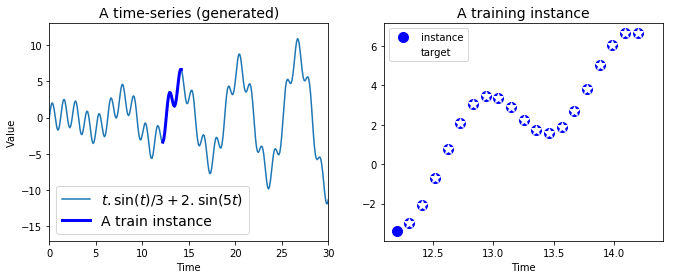

In [46]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title("A time-series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r'$t . \sin(t) / 3 + 2 . \sin(5t)$')
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'b-', linewidth=3, label="A train instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0,30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [47]:
X_batch, y_batch = next_batch(1, n_steps)

In [48]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.70172468,  0.29872116],
       [ 0.29872116,  0.35824052],
       [ 0.35824052,  0.82983016],
       [ 0.82983016,  1.55612277],
       [ 1.55612277,  2.31167196],
       [ 2.31167196,  2.85852465],
       [ 2.85852465,  3.00492137],
       [ 3.00492137,  2.65274897],
       [ 2.65274897,  1.8221236 ],
       [ 1.8221236 ,  0.64707992],
       [ 0.64707992, -0.65658348],
       [-0.65658348, -1.84343634],
       [-1.84343634, -2.69776965],
       [-2.69776965, -3.085645  ],
       [-3.085645  , -2.98690455],
       [-2.98690455, -2.49931275],
       [-2.49931275, -1.81382401],
       [-1.81382401, -1.16704028],
       [-1.16704028, -0.78250729],
       [-0.78250729, -0.81523068]])

In [50]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

n_iterations = 5000
batch_size = 50

saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "d:/tmp/my_time_series_model")

0 	MSE: 11.967254
100 	MSE: 0.525841
200 	MSE: 0.1495599
300 	MSE: 0.07279411
400 	MSE: 0.06158535
500 	MSE: 0.05938873
600 	MSE: 0.05470166
700 	MSE: 0.047849063
800 	MSE: 0.05107608
900 	MSE: 0.047209196
1000 	MSE: 0.047058314
1100 	MSE: 0.047831465
1200 	MSE: 0.04083041
1300 	MSE: 0.047086805
1400 	MSE: 0.041784383
1500 	MSE: 0.048623666
1600 	MSE: 0.050365966
1700 	MSE: 0.042426053
1800 	MSE: 0.032977458
1900 	MSE: 0.04590435
2000 	MSE: 0.040674362
2100 	MSE: 0.03352144
2200 	MSE: 0.03732467
2300 	MSE: 0.04645707
2400 	MSE: 0.038150005
2500 	MSE: 0.03666401
2600 	MSE: 0.034434132
2700 	MSE: 0.03670224
2800 	MSE: 0.035052534
2900 	MSE: 0.031153314
3000 	MSE: 0.034028858
3100 	MSE: 0.041268807
3200 	MSE: 0.036914214
3300 	MSE: 0.03810005
3400 	MSE: 0.043922484
3500 	MSE: 0.037775658
3600 	MSE: 0.04035504
3700 	MSE: 0.039267927
3800 	MSE: 0.032882486
3900 	MSE: 0.040676683
4000 	MSE: 0.038628932
4100 	MSE: 0.039509427
4200 	MSE: 0.040213205
4300 	MSE: 0.03755792
4400 	MSE: 0.037234597

In [54]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "d:/tmp/my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from d:/tmp/my_time_series_model


In [55]:
y_pred

array([[[-3.302047  ],
        [-2.4533572 ],
        [-0.94756925],
        [ 0.7548562 ],
        [ 2.155741  ],
        [ 3.0685909 ],
        [ 3.4678533 ],
        [ 3.3305779 ],
        [ 2.8638768 ],
        [ 2.2052193 ],
        [ 1.6694807 ],
        [ 1.5501645 ],
        [ 1.8984221 ],
        [ 2.7207751 ],
        [ 3.86573   ],
        [ 5.0690894 ],
        [ 6.0499983 ],
        [ 6.61428   ],
        [ 6.6060677 ],
        [ 6.0268455 ]]], dtype=float32)

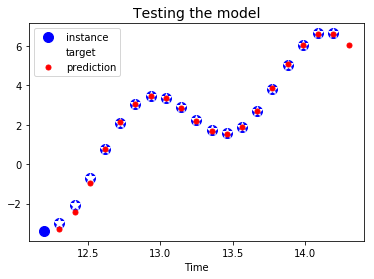

In [56]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## without OutputProjectionWrapper

In [57]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "d:/tmp/my_time_series_model_noproj")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374
1500 	MSE: 0.049654994
1600 	MSE: 0.052740462
1700 	MSE: 0.048069492
1800 	MSE: 0.034612723
1900 	MSE: 0.047547035


In [58]:
y_pred

array([[[-3.392065 ],
        [-2.5145376],
        [-1.2035942],
        [ 0.6889469],
        [ 2.1123097],
        [ 3.0120914],
        [ 3.4587214],
        [ 3.3629668],
        [ 2.8746111],
        [ 2.1655095],
        [ 1.647045 ],
        [ 1.5553131],
        [ 1.9353174],
        [ 2.7615094],
        [ 3.8879666],
        [ 5.1086564],
        [ 6.1134825],
        [ 6.663715 ],
        [ 6.629304 ],
        [ 6.040426 ]]], dtype=float32)

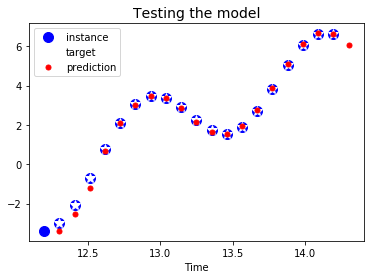

In [59]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [60]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "d:/tmp/my_time_series_model_noproj") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from d:/tmp/my_time_series_model_noproj


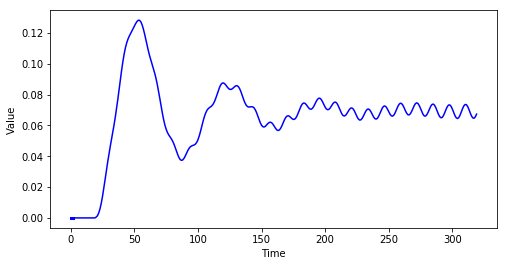

In [61]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from d:/tmp/my_time_series_model_noproj


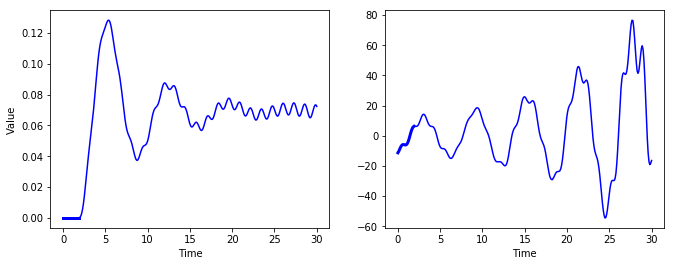

In [62]:
with tf.Session() as sess:
    saver.restore(sess, "d:/tmp/my_time_series_model_noproj")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")

plt.show()


In [69]:
X_batch, y_batch = next_batch(50, n_steps)

In [70]:
X_batch.shape

(50, 20, 1)

In [72]:
X_batch[0]

array([[ 2.01121816],
       [ 1.92703069],
       [ 2.24242286],
       [ 2.80429408],
       [ 3.39010802],
       [ 3.76312526],
       [ 3.73120911],
       [ 3.19479937],
       [ 2.17229975],
       [ 0.79665371],
       [-0.71606309],
       [-2.11835546],
       [-3.19067681],
       [-3.79392991],
       [-3.90225865],
       [-3.60811538],
       [-3.09837617],
       [-2.60736483],
       [-2.35830012],
       [-2.50751455]])